# ASFPM 2020

In [1]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from utils import *
import os
from IPython.display import Image

### Enter Station ID 

In [2]:
gage = "01646500"
state = "MD"

gage_url = f'https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no={gage}'
Url(gage_url)

Url(_Url__url='https://waterdata.usgs.gov/nwis/inventory?agency_code=USGS&site_no=01646500')

### Generate URL and read data

In [3]:
stats_uri = f'https://nwis.waterdata.usgs.gov/{state}/nwis/peak?site_no={gage}&agency_cd=USGS&format=rdb'
Url(stats_uri)

Url(_Url__url='https://nwis.waterdata.usgs.gov/MD/nwis/peak?site_no=01646500&agency_cd=USGS&format=rdb')

In [4]:
peaks = pd.read_table(stats_uri, comment = "#")
peaks = peaks[1:].reset_index(drop=True)
peaks['peak_va'] = pd.to_numeric(peaks['peak_va'] )
peaks['peak_dt'] = pd.to_datetime(peaks['peak_dt'])
peaks.head()

agency_cd   site_no    peak_dt peak_tm  peak_va peak_cd gage_ht gage_ht_cd  \
0      USGS  01646500 1931-04-03     NaN    37900     NaN    6.90        NaN   
1      USGS  01646500 1932-05-14     NaN   168000     NaN   15.25        NaN   
2      USGS  01646500 1933-04-22     NaN   127000     NaN   12.80        NaN   
3      USGS  01646500 1934-09-18     NaN    53500     NaN    7.80        NaN   
4      USGS  01646500 1934-12-02     NaN   139000     NaN   13.50        NaN   

  year_last_pk ag_dt ag_tm ag_gage_ht ag_gage_ht_cd  
0          NaN   NaN   NaN        NaN           NaN  
1          NaN   NaN   NaN        NaN           NaN  
2          NaN   NaN   NaN        NaN           NaN  
3          NaN   NaN   NaN        NaN           NaN  
4          NaN   NaN   NaN        NaN           NaN

# View Annual Maxima

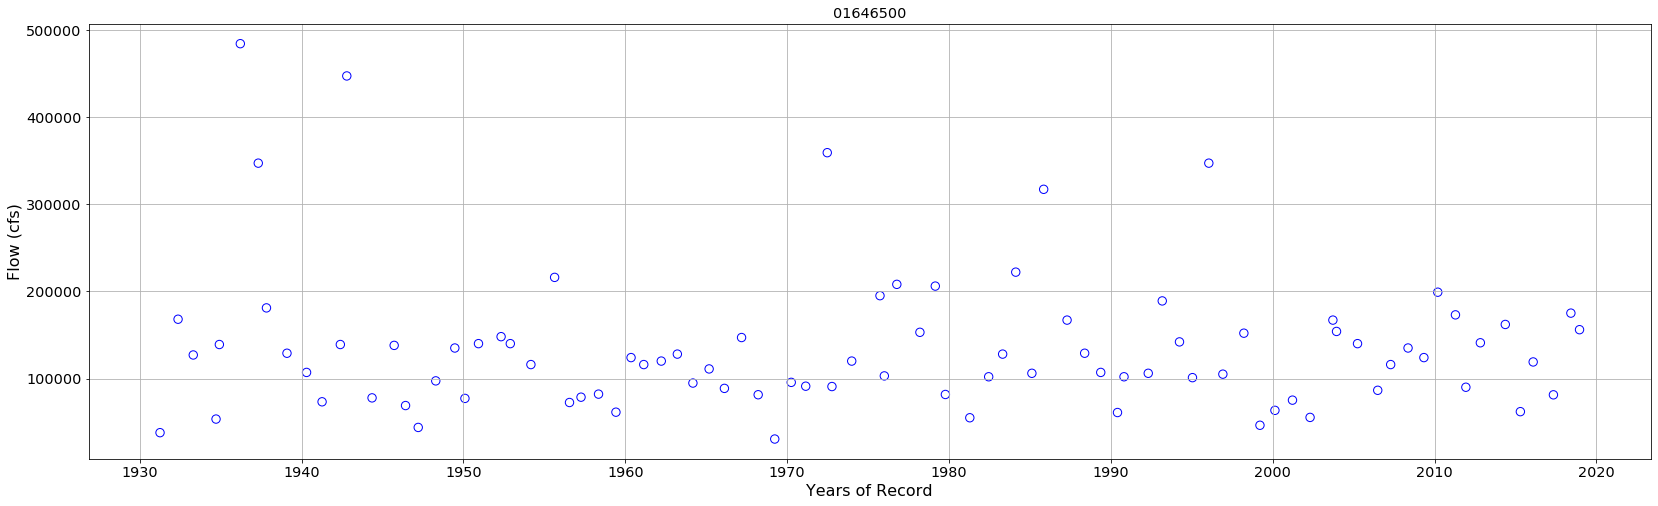

In [5]:
fig, ax = plt.subplots(figsize=(28,8))
ax.scatter(x= peaks.peak_dt.values, y = peaks.peak_va.values,  color="none", edgecolor="blue", s= 70);ax.grid();
ax.set_title(gage);ax.set_ylabel('Flow (cfs)', fontsize=16);ax.set_xlabel('Years of Record', fontsize=16);
# ax.axhline(250000, 0,365, color='red')

# Select a year and plot the mean daily flow

In [6]:
year= 1996
# Auto generate url string
daily_uri = f"https://waterdata.usgs.gov/{state}/nwis/dv?cb_00060=on&format=rdb&site_no={gage}&referred_module=sw&period=&begin_date={year-1}-10-01&end_date={year}-9-30"
Url(daily_uri)

Url(_Url__url='https://waterdata.usgs.gov/MD/nwis/dv?cb_00060=on&format=rdb&site_no=01646500&referred_module=sw&period=&begin_date=1995-10-01&end_date=1996-9-30')

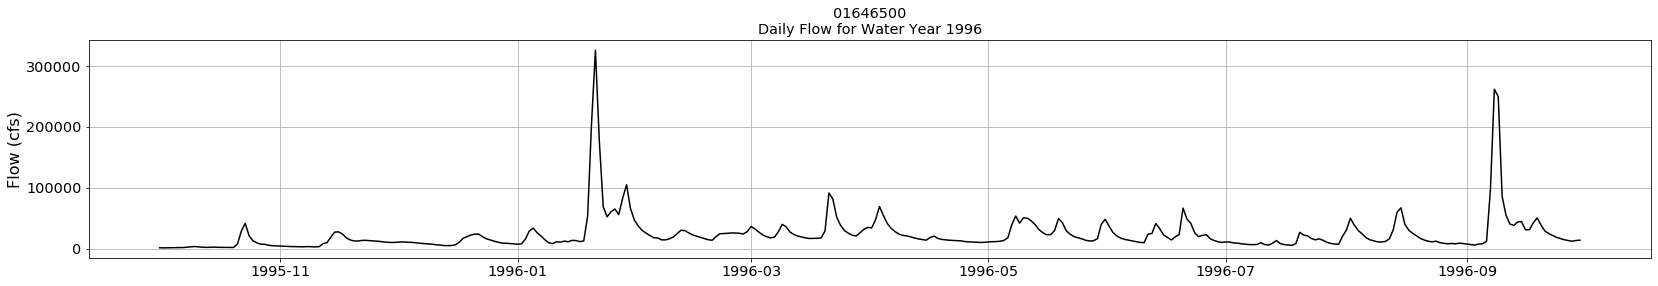

In [7]:
daily = pd.read_table(daily_uri, comment = "#")
daily = daily[1:].reset_index(drop=True)
daily['datetime'] = pd.to_datetime(daily['datetime'])
flow_col = daily.columns[3]
daily[flow_col] = pd.to_numeric(daily[flow_col]) 

fig, ax = plt.subplots(figsize=(28,4))
ax.plot(daily.datetime,daily[flow_col].values,  color="black");ax.grid();
ax.set_title(f'{gage}\nDaily Flow for Water Year {year}');ax.set_ylabel('Flow (cfs)', fontsize=16);
# ax.axhline(250000, 0,365, color='red');

# Sort and Rank the Peak Annual Flows

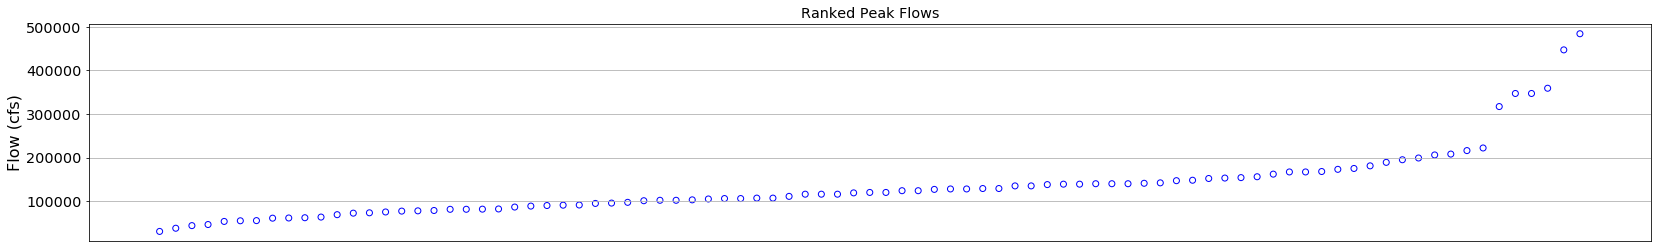

In [8]:
fig, ax = plt.subplots(figsize=(28,4))
ax.scatter(x= np.arange(0, len(peaks.peak_va)), y = sorted(peaks.peak_va.values, reverse=True),  color="none", edgecolor="blue");ax.invert_xaxis()
ax.set_xlabel(f"{len(peaks.peak_va)} Samples");ax.set_ylabel('Flow (cfs)', fontsize=16);ax.grid();ax.set_title("Ranked Peak Flows");ax.get_xaxis().set_visible(False)

### Calculate the Empirical Distribution

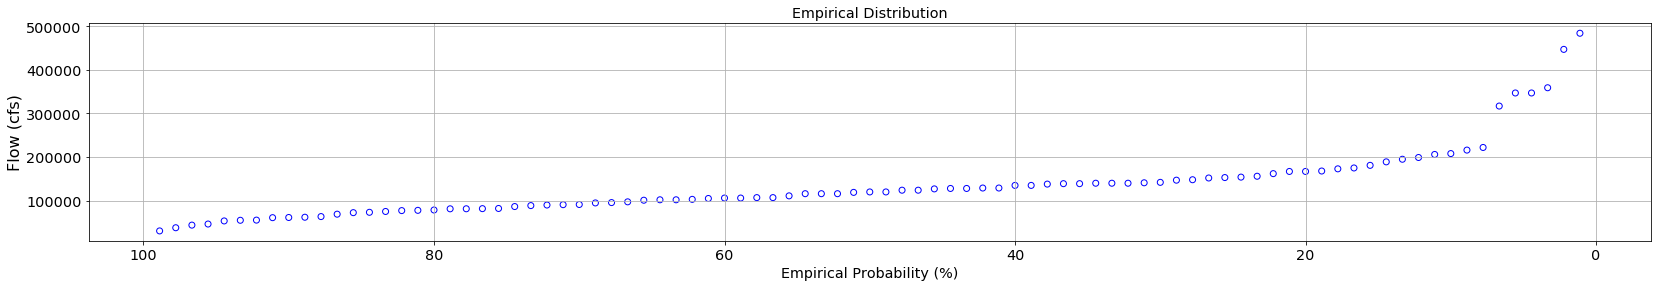

In [9]:
def ecdf(data):
    """ Compute ECDF """
    x = sorted(data, reverse=True)
    n = len(data)
    y = np.arange(1, n+1) / (n+1)
    return x, y

emp_q, emp_ri = ecdf(peaks.peak_va)
fig, ax = plt.subplots(figsize=(28,4))
ax.scatter(x= emp_ri*100, y = emp_q,  color="none", edgecolor="blue");ax.invert_xaxis()
ax.set_xlabel(f"Empirical Probability (%)");ax.set_ylabel('Flow (cfs)', fontsize=16);ax.grid();ax.set_title("Empirical Distribution");

### Convert to log & compute moments

In [10]:
# Look up regional skew & mse for station
rskew = 0.55
rskew_mse = 0.2025

In [11]:
lp3_data = LP3(peaks.peak_va)

log_peaks = lp3_data.log
skew =  lp3_data.weighted_skew(rskew, rskew_mse)
mu = lp3_data.log.mean()
sigma = lp3_data.log.std()

print(f"Mean (Log): \t\t{mu}\nStandard Deviation: \t{sigma}\nStation Skew: \t\t{skew}")

Mean (Log): 		5.071491722982058
Standard Deviation: 	0.22284509421165621
Station Skew: 		0.30873558445993743


### Calculate LPII and Plot

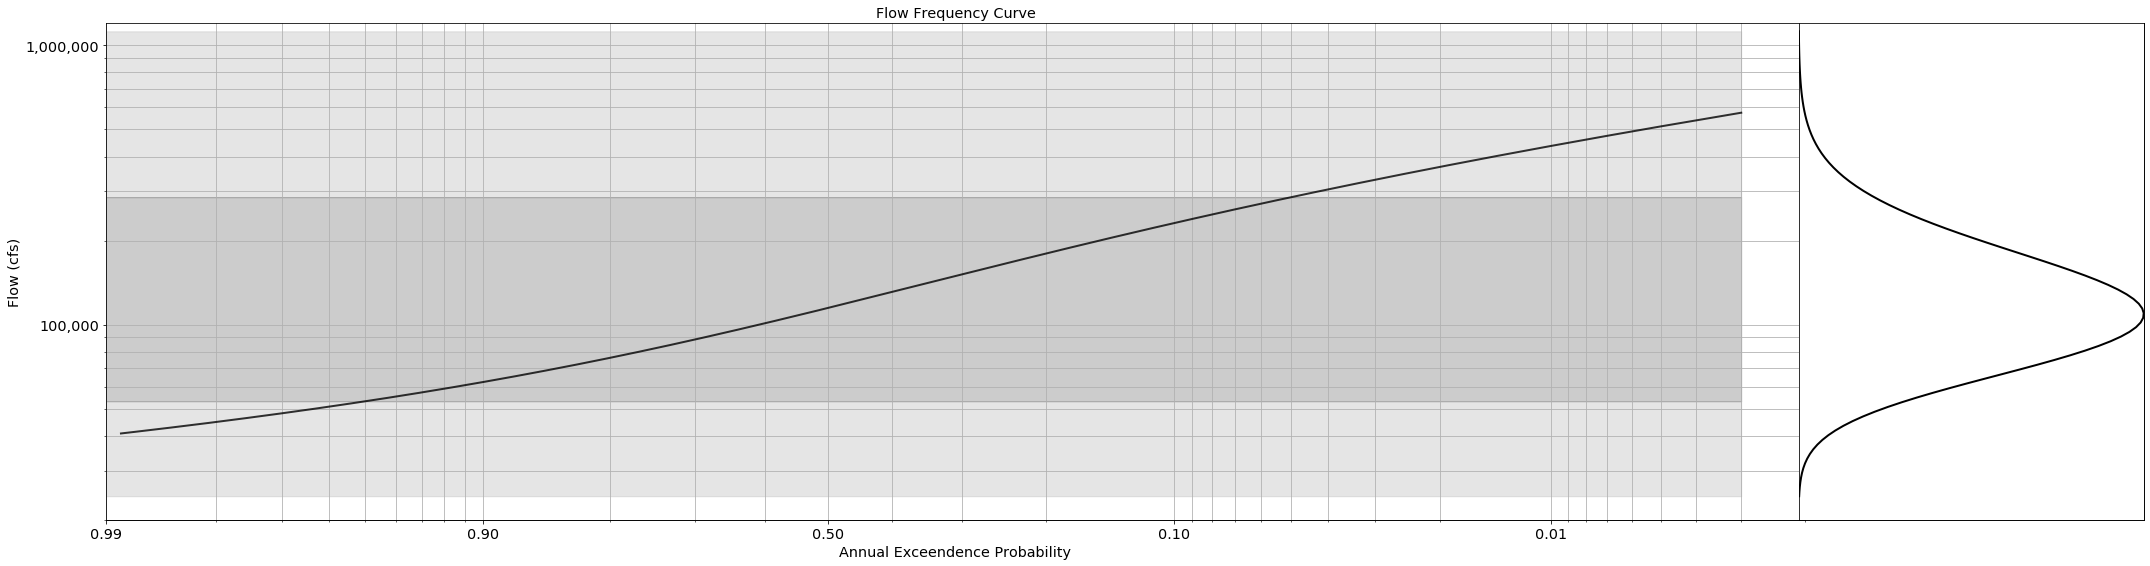

In [12]:
# LPII Curve using Gage moments
aeps = np.arange(0.002, 1, .001)
aep_qs = lp3_data.lp3_values(aeps, rskew, rskew_mse)
plot_aep_full(aeps, aep_qs, skew, mu, sigma, color = "Brown", ci=95);
# fig, ax = add_emperical_plot_full;

# Plot the PDF with the Observed Data

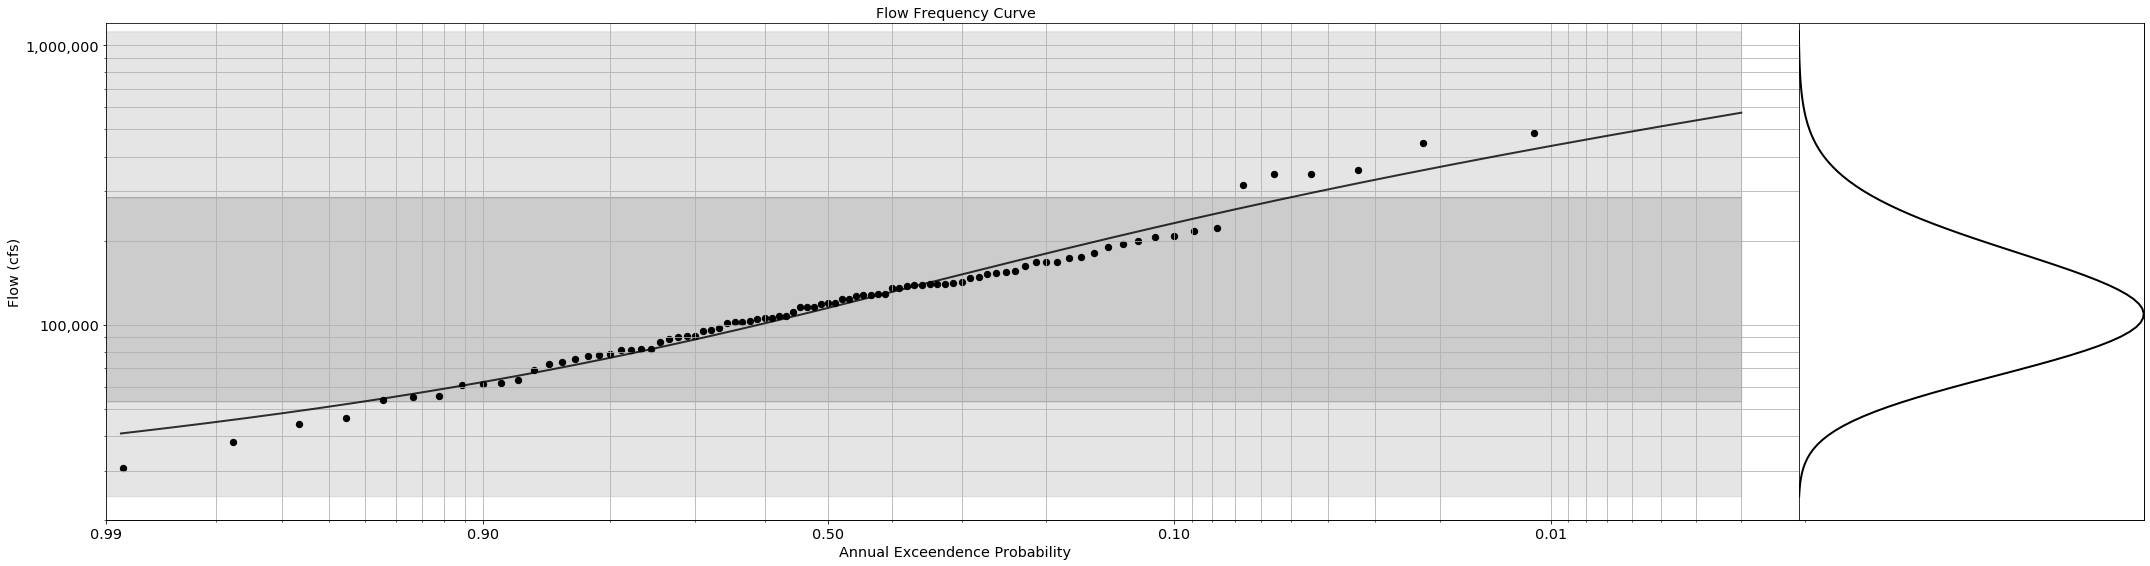

In [13]:
# f, a = plot_aep_full(aeps, aep_qs, skew, mu, sigma)
add_emperical_plot_full(aeps, aep_qs, emp_q,emp_ri, skew, mu, sigma, color = "Black");

# Boostrapping

### Method #1

### Select random variates generated using the LP III Distribution calculated from the complete set of Gage Records

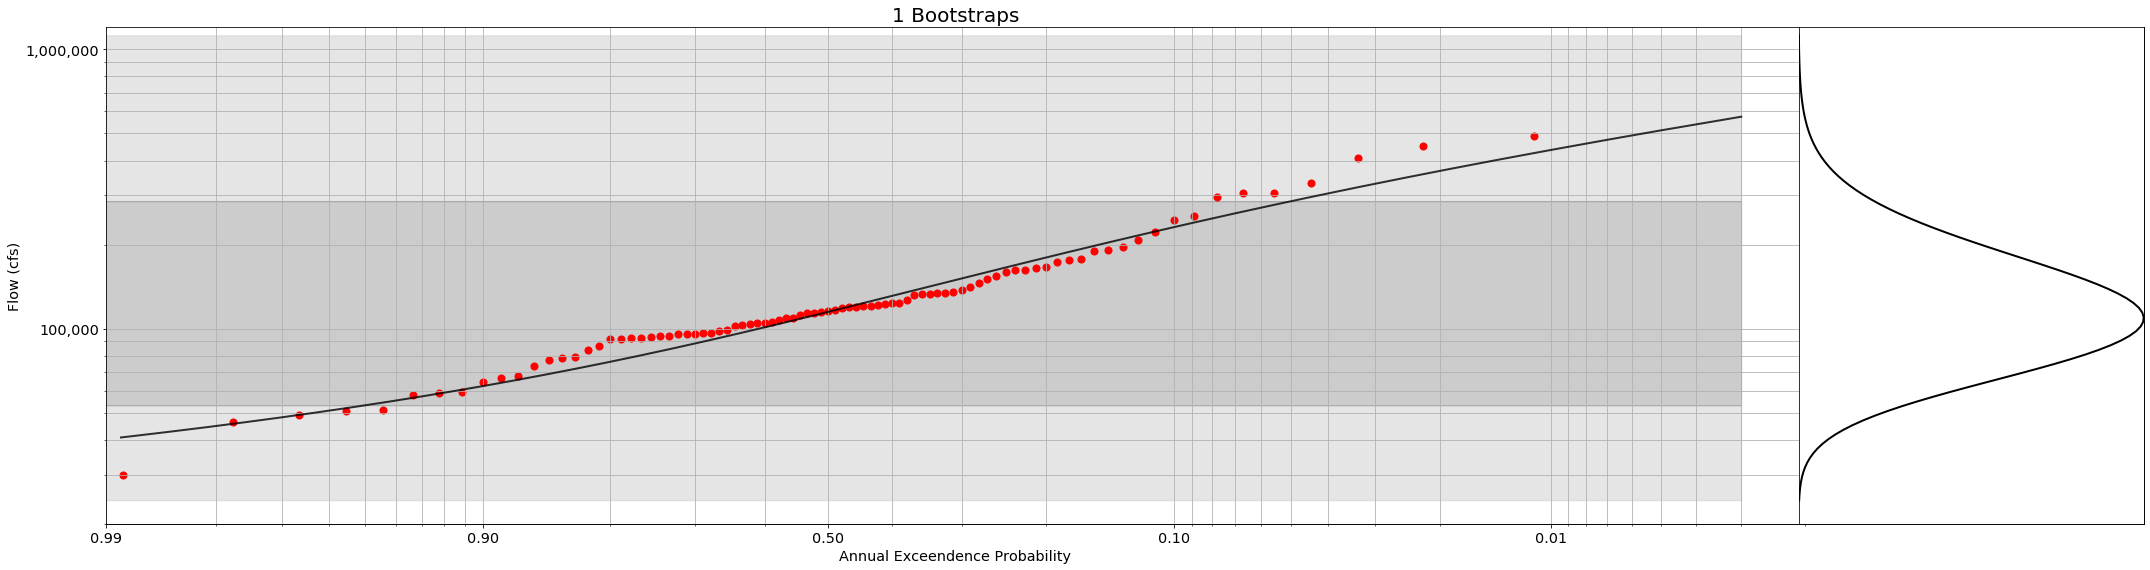

In [14]:
n= 89
bootstraps = 1
data = add_bootstrap_plot_full(aeps, aep_qs, skew, mu, sigma, nbs=bootstraps, nsamples=n, color = 'red', s=50)

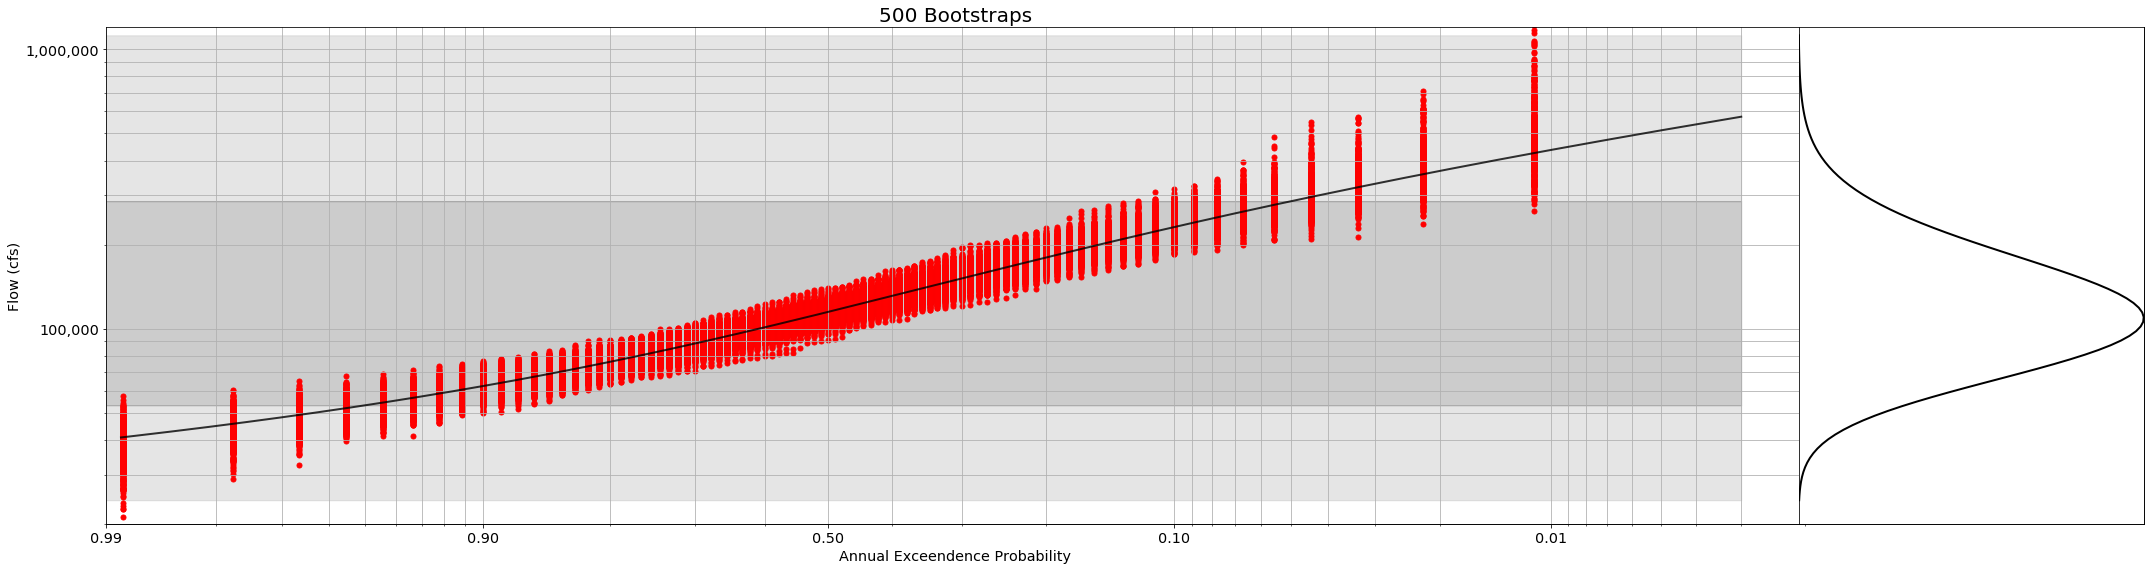

In [15]:
n= 89
bootstraps = 500
data = add_bootstrap_plot_full(aeps, aep_qs, skew, mu, sigma, nbs=bootstraps, nsamples=n, color = 'red')

### Method #2

### Select random variates by choosing a subset of the Gage Records and fitting LP III to the subset

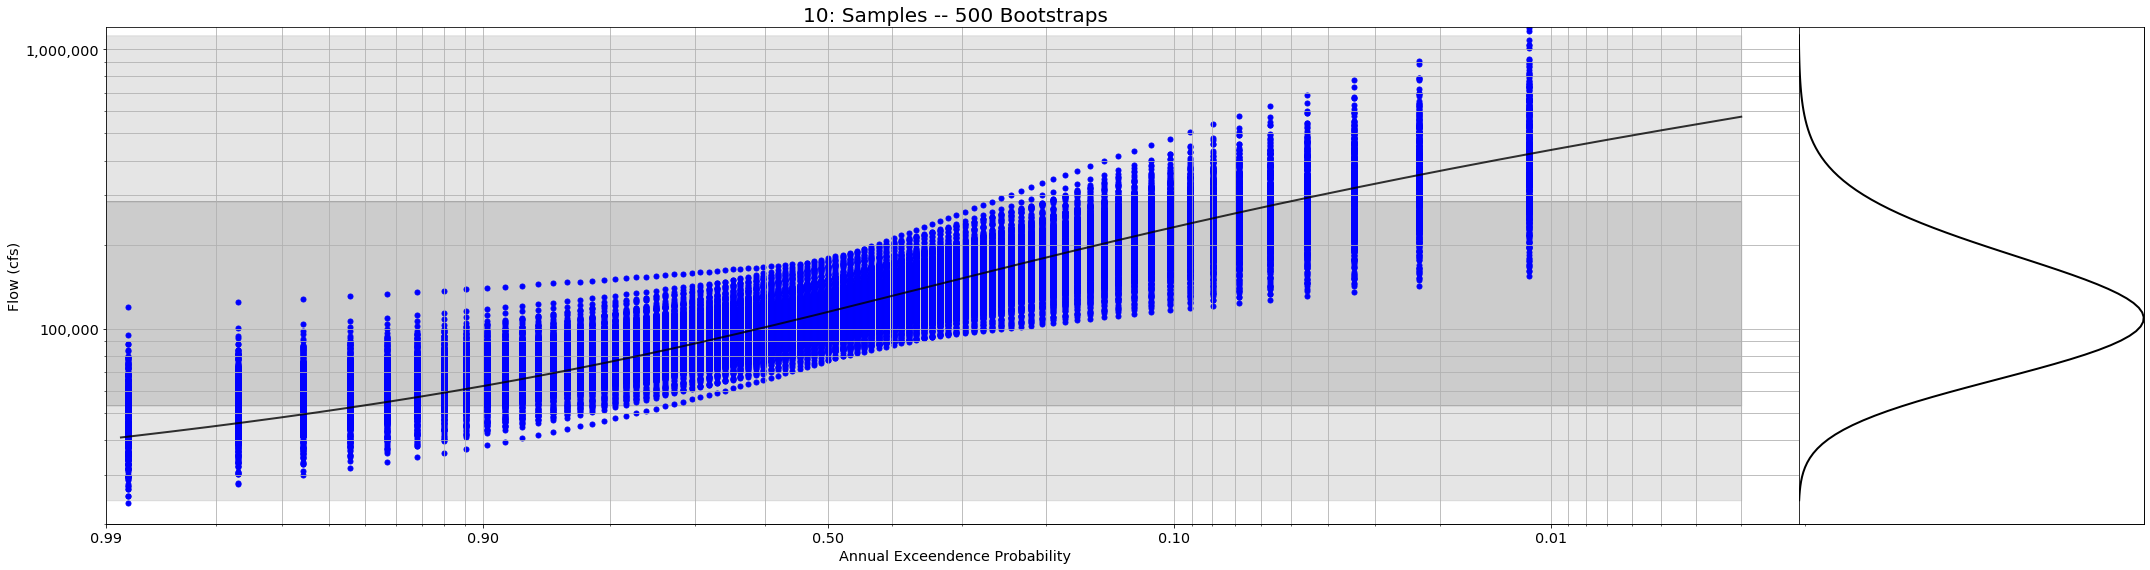

In [16]:
n= 10
bootstraps = 500
data = add_bootstrap_plot_from_sample_pop_full(aeps, aep_qs, skew, mu, sigma, rskew, rskew_mse,  nbs=bootstraps, nsamples=n, nx=89,color = 'blue')

In [17]:
# n= 20
# bootstraps = 10
# data = add_bootstrap_plot_from_sample_pop_full(aeps, aep_qs, skew, mu, sigma, rskew, rskew_mse,  nbs=bootstraps, nsamples=n, nx=89,color = 'blue')

In [18]:
# n= 50
# bootstraps = 10
# data = add_bootstrap_plot_from_sample_pop_full(aeps, aep_qs, skew, mu, sigma, rskew, rskew_mse,  nbs=bootstraps, nsamples=n, nx=89,color = 'blue')

### Realizations

In [19]:
%%capture
n= 89
image_list, image_files = [],[]

bootstraps=[1,2,5,10,25,50,100,200,500,1000,5000,10000]

root = os.getcwd()
gifdir = pl.Path(root)



for realization, bootstrap in enumerate(bootstraps):
    data = add_bootstrap_plot_full(aeps, aep_qs, skew, mu, sigma, nbs=bootstrap, nsamples=n, color='black')
    img = gifdir/"images"/f'{realization}.png' 
    data[0].savefig(img)
    image_files.append(img)
    image_list.append(imageio.imread(img))

imageio.mimwrite(gifdir/"images"/f'bootstraps.gif', image_list, duration=1.5)

In [20]:
# Clean up temporay files
for image in image_files:
    os.remove(image)

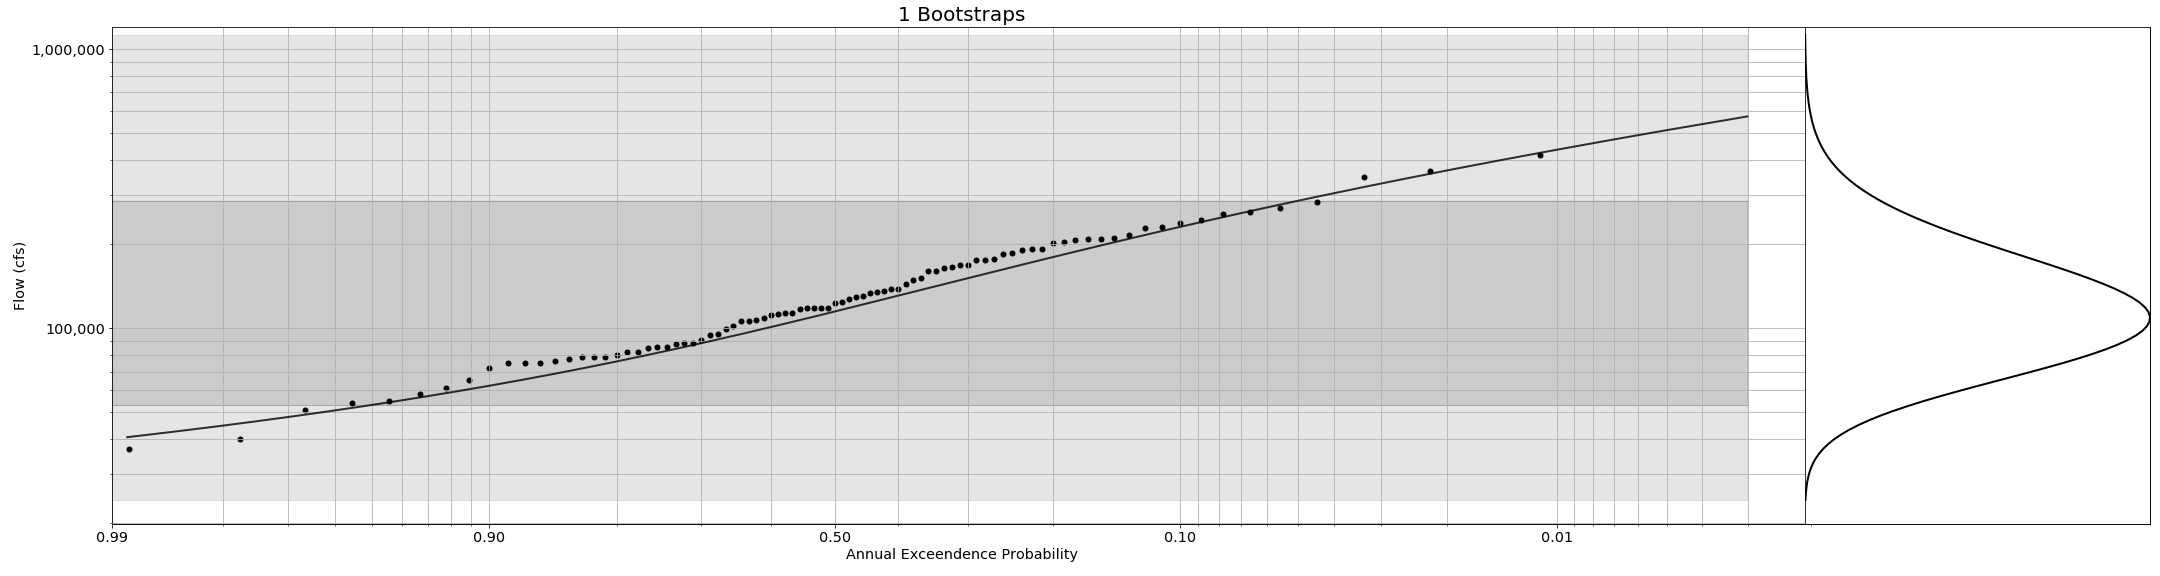

In [21]:
with open(gifdir/"images"/"bootstraps.gif",'rb') as file:
    display(Image(file.read()))

### Confidence for Each Recurrence Interval

In [22]:
n= 89
bootstraps = 1
realizations = []
for i in range(1000):
    r = np.random.choice(aep_qs, size=n)
    emp_q,emp_ri  = ecdf(r)
    realizations.append(dict(zip(emp_ri,sorted(emp_q,reverse=True))))
    
    
df = pd.DataFrame(realizations).T
df.head()

0              1              2              3    \
0.011111  426466.413588  402027.143690  436364.292451  460083.951451   
0.022222  350389.758858  395191.454865  339625.933830  350389.758858   
0.033333  324410.922622  377452.144648  314073.076727  343055.381339   
0.044444  307143.273503  343055.381339  302852.081969  319068.759086   
0.055556  293088.830909  271112.012680  281276.316861  286108.405095   

                    4              5              6              7    \
0.011111  447467.430180  372280.553210  327226.650237  538914.978774   
0.022222  436364.292451  327226.650237  314073.076727  362812.705764   
0.033333  395191.454865  311692.363093  302852.081969  319068.759086   
0.044444  372280.553210  296842.350692  298792.480322  293088.830909   
0.055556  367411.269132  293088.830909  287792.547216  276744.518784   

                    8              9    ...            990            991  \
0.011111  538914.978774  626197.871466  ...  377452.144648  512655.937277   
0.022222  417549.684410  538914.978774  ...  354323.609519  354323.609519   
0.033333  377452.144648  372280.553210  ...  298792.480322  289516.120893   
0.044444  311692.363093  350389.758858  ...  279734.129711  289516.120893   
0.055556  302852.081969  333182.288497  ...  276744.518784  273873.349134   

                    992            993            994            995  \
0.011111  367411.269132  512655.937277  327226.650237  538914.978774   
0.022222  362812.705764  409446.220920  307143.273503  409446.220920   
0.033333  354323.609519  367411.269132  289516.120893  346638.806571   
0.044444  346638.806571  343055.381339  238992.056972  343055.381339   
0.055556  330147.870596  316530.283694  231669.914222  307143.273503   

                    996            997            998            999  
0.011111  282851.815973  372280.553210  316530.283694  367411.269132  
0.022222  281276.316861  362812.705764  302852.081969  358457.889105  
0.033333  264640.391020  346638.806571  291280.912828  350389.758858  
0.044444  263413.541285  298792.480322  284462.019069  336338.462441  
0.055556  262207.481254  287792.547216  252188.617612  319068.759086  

[5 rows x 1000 columns]

In [23]:
x0 = df.iloc[0].values